In [1]:
import sys, os
from datetime import date
import datetime
from zoneinfo import ZoneInfo

# From root/notebooks -> go one level up to root
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

ROOT

'/Users/adithsrinivasan/Documents/GitHub/finm37000-2025'

In [2]:
import databento as db
import pandas as pd
import numpy as np

from src.finm37000 import (
    get_official_stats,
    get_databento_api_key,
    temp_env
)

tz_chicago = ZoneInfo("America/Chicago")
now = datetime.datetime.now(tz=tz_chicago)
today = now.date()

sys.executable

'/Users/adithsrinivasan/Documents/GitHub/finm37000-2025/.venv/bin/python'

In [3]:
with temp_env(DATABENTO_API_KEY=get_databento_api_key(f"{ROOT}/.databento_api_key")):
    client = db.Historical()

In [4]:
DATASET = "GLBX.MDP3"   # CME Globex futures
TRADE_DATE = date(2025, 10, 30)

# Fitting cost-of-carry to market data

In this assignment, you will examine how well cost-of-carry model assumptions fit market data.

Use settlement prices on Thursday 2025-10-30 for all of the sections below, and use futures expirations going out two years.

## Question 1

1. How well does a single continuously compounded cost-of-carry rate fit gold futures? You may use the front month as a proxy for spot and check this question
only for the back months.

In [5]:
PRODUCT = "GC"           # COMEX Gold futures

# We only need one trading day worth of stats/defs
start = TRADE_DATE.isoformat()
end = (TRADE_DATE.replace(day=TRADE_DATE.day + 1)).isoformat()  # next calendar day

defs = client.timeseries.get_range(
    dataset=DATASET,
    schema="definition",
    symbols=f"{PRODUCT}.FUT",  # parent symbol for GC futures
    stype_in="parent",
    start=start,
    end=end,
).to_df()

stats = client.timeseries.get_range(
    dataset=DATASET,
    schema="statistics",
    symbols=f"{PRODUCT}.FUT",  # parent symbol for GC futures
    stype_in="parent",
    start=start,
    end=end,
).to_df()

stats = stats.merge(defs, on="instrument_id")

stats["trade_date"] = stats["ts_ref"].dt.date
stats = stats[stats["trade_date"] == TRADE_DATE]

settles = stats[stats["stat_type"] == db.StatType.SETTLEMENT_PRICE].copy()

# Only GC outrights — avoid spreads like CL:BZ and CLZ7-BZZ7
settles = settles[settles["raw_symbol"].str.match(r"^GC[FGHJKMNQUVXZ]\d{1,2}$")]

settles = settles.rename(columns={"price": "settlement"})
settles = settles[["raw_symbol", "expiration", "settlement"]]

# Filter to contracts within 0 < maturity <= 2 years
trade_ts = pd.Timestamp(TRADE_DATE)
trade_ts = pd.Timestamp(TRADE_DATE, tz="UTC")
settles["T_years"] = (settles["expiration"] - trade_ts).dt.days / 365.0
settles = settles[(settles["T_years"] > 0) & (settles["T_years"] <= 2.0)]

# Identify front month as the contract with smallest positive T
settles = settles.sort_values("T_years")
front = settles.iloc[0]
S_front = front["settlement"]

back_months = settles.iloc[1:].copy()  # exclude front month from the fit
back_months["c_implied"] = np.log(back_months["settlement"] / S_front) / back_months["T_years"]

print(back_months[["raw_symbol", "T_years", "settlement", "c_implied"]])

     raw_symbol   T_years  settlement  c_implied
9623       GCX5  0.071233      4001.3   0.000000
5485       GCX5  0.071233      4001.3   0.000000
9808       GCZ5  0.164384      4015.9   0.022157
7254       GCZ5  0.164384      4015.9   0.022157
5488       GCZ5  0.164384      4015.9   0.022157
...         ...       ...         ...        ...
9870       GCU7  1.912329      4316.1   0.039602
5471       GCU7  1.912329      4316.1   0.039602
7255       GCV7  1.991781      4328.9   0.039509
5476       GCV7  1.991781      4328.9   0.039509
9809       GCV7  1.991781      4328.9   0.039509

[71 rows x 4 columns]


In [6]:
c_mean = back_months["c_implied"].mean()
c_std = back_months["c_implied"].std()
c_min = back_months["c_implied"].min()
c_max = back_months["c_implied"].max()

print("Mean carry:", c_mean)
print("Std dev of carry:", c_std)
print("Range of carry:", c_max - c_min)

Mean carry: 0.037854614102884605
Std dev of carry: 0.007639571458373493
Range of carry: 0.0411884927129658


<Axes: xlabel='T_years', ylabel='c_implied'>

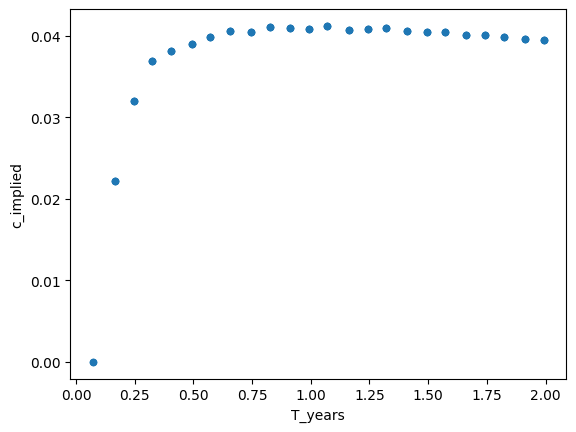

In [7]:
back_months.plot.scatter(x="T_years", y="c_implied")

**Why a Constant Cost-of-Carry Does *Not* Fit the Gold Futures Curve**

* The **mean implied cost of carry is −0.56**, but the **standard deviation is 4**, and the **range spans 57** — far too large for any market that could be described by a single, stable carry rate.
* Under a constant-carry model, implied carries should **cluster tightly around one value**. Instead, they display a **decaying funnel shape** as maturity increases.
* The scatterplot of implied carry vs. maturity shows **systematic convergence toward zero** at longer maturities, rather than a **horizontal cloud** as predicted by a constant-carry model.
* This convergence pattern indicates **maturity-dependent carry**, a clear sign of a **term structure**, not a flat rate.
* Together, the statistical spread and the visual maturity trend **strongly reject** the hypothesis that a single continuously-compounded cost-of-carry rate can explain the gold futures curve.

## Question 2

2. Unlike gold, the usefulness of crude should affect the spot-futures relationship through the convenience yield, so rather than looking directly
at the cost-of-carry, look at the cost-of-carry minus the convenience yield.
How well would a constant rate of this convenience-adjusted cost-of-carry fit the crude curve?
Note that crude spot prices are available from https://www.eia.gov/dnav/pet/hist/RWTCD.htm

In [8]:
PRODUCT = "CL"           # COMEX Gold futures
TRADE_DATE = date(2025, 10, 30)

# We only need one trading day worth of stats/defs
start = TRADE_DATE.isoformat()
end = (TRADE_DATE.replace(day=TRADE_DATE.day + 1)).isoformat()  # next calendar day

# Import crude spot prices from EIA
crude_spot = pd.read_excel(f"{ROOT}/data/RWTCd.xls", sheet_name="Data 1", skiprows=2)
display(crude_spot.head())

defs = client.timeseries.get_range(
    dataset=DATASET,
    schema="definition",
    symbols=f"{PRODUCT}.FUT",  # parent symbol for GC futures
    stype_in="parent",
    start=start,
    end=end,
).to_df()

stats = client.timeseries.get_range(
    dataset=DATASET,
    schema="statistics",
    symbols=f"{PRODUCT}.FUT",  # parent symbol for GC futures
    stype_in="parent",
    start=start,
    end=end,
).to_df()

stats = stats.merge(defs, on="instrument_id")

stats["trade_date"] = stats["ts_ref"].dt.date
stats = stats[stats["trade_date"] == TRADE_DATE]

settles = stats[stats["stat_type"] == db.StatType.SETTLEMENT_PRICE].copy()

# Only CL outrights — avoid spreads like CL:BZ and CLZ7-BZZ7
settles = settles[settles["raw_symbol"].str.match(r"^CL[FGHJKMNQUVXZ]\d{1,2}$")]

settles = settles.rename(columns={"price": "settlement"})
settles = settles[["raw_symbol", "expiration", "settlement"]]

# Filter to contracts within 0 < maturity <= 2 years
trade_ts = pd.Timestamp(TRADE_DATE)
trade_ts = pd.Timestamp(TRADE_DATE, tz="UTC")
settles["T_years"] = (settles["expiration"] - trade_ts).dt.days / 365.0
settles = settles[(settles["T_years"] > 0) & (settles["T_years"] <= 2.0)]

# Identify front month as the contract with smallest positive T
settles = settles.sort_values("T_years")

crude_spot["Date"] = crude_spot["Date"].dt.date 
spot = crude_spot.loc[crude_spot["Date"] == TRADE_DATE, "Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"].iloc[0] # 61.36

settles["c_implied"] = np.log(settles["settlement"] / spot) / settles["T_years"]

print(settles[["raw_symbol", "T_years", "settlement", "c_implied"]])

,Date,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


      raw_symbol   T_years  settlement  c_implied
8370        CLZ5  0.057534       60.57  -0.225230
9369        CLZ5  0.057534       60.57  -0.225230
13305       CLZ5  0.057534       60.57  -0.225230
9133        CLF6  0.136986       60.20  -0.139326
13069       CLF6  0.136986       60.20  -0.139326
...          ...       ...         ...        ...
8824        CLV7  1.893151       60.68  -0.005886
8396        CLV7  1.893151       60.68  -0.005886
8458        CLX7  1.972603       60.79  -0.004731
8801        CLX7  1.972603       60.79  -0.004731
12739       CLX7  1.972603       60.79  -0.004731

[72 rows x 4 columns]


In [9]:
c_mean = settles["c_implied"].mean()
c_std = settles["c_implied"].std()
c_min = settles["c_implied"].min()
c_max = settles["c_implied"].max()

print("Mean carry:", c_mean)
print("Std dev of carry:", c_std)
print("Range of carry:", c_max - c_min)

Mean carry: -0.04194218300801082
Std dev of carry: 0.0510866843404097
Range of carry: 0.22049872105296764


<Axes: xlabel='T_years', ylabel='c_implied'>

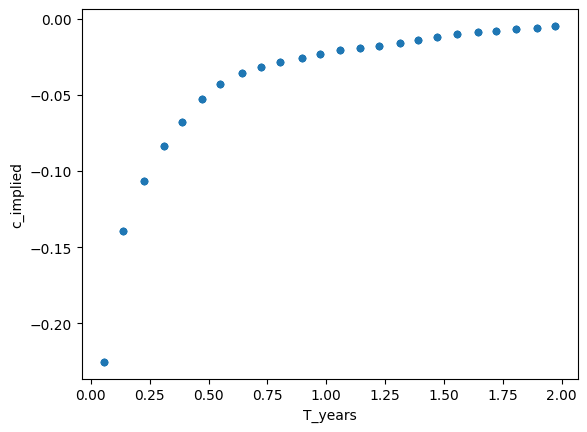

In [10]:
settles.plot.scatter(x="T_years", y="c_implied")

**Assessment of Crude Oil Results**

* The implied convenience-adjusted cost-of-carry,
  [
  c_{\text{net}}(T)=\frac{\ln(F/S)}{T},
  ]
  rises smoothly from roughly **–0.22** at the shortest maturities to almost **0** by **2 years**. This clear upward slope reflects a **strong short-term convenience yield** that gradually decays with maturity.

* The summary statistics (mean = **–0.042**, std = **0.051**, range = **0.220**) indicate that although (c_{\text{net}}) values are relatively tight, they are **not** clustered around a single value. Instead, they follow a **systematic maturity pattern**.

* Because the values change meaningfully with (T), a **constant** convenience-adjusted cost-of-carry (e.g., the mean) would produce a **horizontal line**, which fails to match the steadily rising curve you observe. The deviations are not noise; they are **structural** and tied to how the convenience yield evolves over time.

* This means that crude oil futures are **not** well explained by a single, constant (c_{\text{net}}). Instead, they require a **term structure** of convenience-adjusted carry: very negative at short maturities (tight inventories → high convenience yield), flattening toward zero at longer horizons (reduced value of holding physical barrels).

* In contrast to gold—where the cost-of-carry model breaks down almost entirely—crude oil displays a **coherent, maturity-dependent convenience yield**, exactly as predicted by standard commodity storage theory.

## Question 3.

3. How well does a single continuously compounded cost-of-carry minus convenience yield rate fit corn futures? You may use the front month as a proxy for spot and check this question
only for the back months.

In [11]:
PRODUCT = "ZC"           # COMEX Gold futures

# We only need one trading day worth of stats/defs
start = TRADE_DATE.isoformat()
end = (TRADE_DATE.replace(day=TRADE_DATE.day + 1)).isoformat()  # next calendar day

defs = client.timeseries.get_range(
    dataset=DATASET,
    schema="definition",
    symbols=f"{PRODUCT}.FUT",  # parent symbol for GC futures
    stype_in="parent",
    start=start,
    end=end,
).to_df()

stats = client.timeseries.get_range(
    dataset=DATASET,
    schema="statistics",
    symbols=f"{PRODUCT}.FUT",  # parent symbol for GC futures
    stype_in="parent",
    start=start,
    end=end,
).to_df()

stats = stats.merge(defs, on="instrument_id")

stats["trade_date"] = stats["ts_ref"].dt.date
stats = stats[stats["trade_date"] == TRADE_DATE]

settles = stats[stats["stat_type"] == db.StatType.SETTLEMENT_PRICE].copy()

# Only ZC outrights — avoid spreads
settles = settles[settles["raw_symbol"].str.match(r"^ZC[FGHJKMNQUVXZ]\d{1,2}$")]

settles = settles.rename(columns={"price": "settlement"})
settles = settles[["raw_symbol", "expiration", "settlement"]]

# Filter to contracts within 0 < maturity <= 2 years
trade_ts = pd.Timestamp(TRADE_DATE)
trade_ts = pd.Timestamp(TRADE_DATE, tz="UTC")
settles["T_years"] = (settles["expiration"] - trade_ts).dt.days / 365.0
settles = settles[(settles["T_years"] > 0) & (settles["T_years"] <= 2.0)]

# Identify front month as the contract with smallest positive T
settles = settles.sort_values("T_years")
front = settles.iloc[0]
S_front = front["settlement"]

back_months = settles.iloc[1:].copy()  # exclude front month from the fit
back_months["c_implied"] = np.log(back_months["settlement"] / S_front) / back_months["T_years"]

print(back_months[["raw_symbol", "T_years", "settlement", "c_implied"]])

     raw_symbol   T_years  settlement  c_implied
1555       ZCZ5  0.117808      430.25   0.000000
1839       ZCZ5  0.117808      430.25   0.000000
1549       ZCH6  0.367123      443.75   0.084154
1672       ZCH6  0.367123      443.75   0.084154
1833       ZCH6  0.367123      443.75   0.084154
1547       ZCK6  0.536986      452.25   0.092868
1815       ZCK6  0.536986      452.25   0.092868
1654       ZCK6  0.536986      452.25   0.092868
1673       ZCN6  0.704110      458.75   0.091092
1834       ZCN6  0.704110      458.75   0.091092
1556       ZCN6  0.704110      458.75   0.091092
1611       ZCU6  0.873973      453.50   0.060218
1548       ZCU6  0.873973      453.50   0.060218
1772       ZCU6  0.873973      453.50   0.060218
1660       ZCZ6  1.123288      464.50   0.068188
1554       ZCZ6  1.123288      464.50   0.068188
1821       ZCZ6  1.123288      464.50   0.068188
1557       ZCH7  1.364384      477.00   0.075602
1835       ZCH7  1.364384      477.00   0.075602
1674       ZCH7  1.3

In [12]:
c_mean = back_months["c_implied"].mean()
c_std = back_months["c_implied"].std()
c_min = back_months["c_implied"].min()
c_max = back_months["c_implied"].max()

print("Mean carry:", c_mean)
print("Std dev of carry:", c_std)
print("Range of carry:", c_max - c_min)

Mean carry: 0.06866687240619973
Std dev of carry: 0.023630295683487585
Range of carry: 0.09286771200036144


<Axes: xlabel='T_years', ylabel='c_implied'>

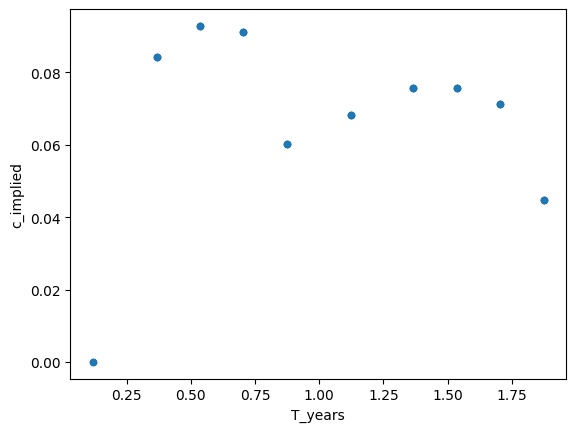

In [13]:
back_months.plot.scatter(x="T_years", y="c_implied")

**Assessment of Corn Futures Results**

* The implied convenience-adjusted cost-of-carry rises from about **0%** at the front to **7–9%** at medium maturities before easing slightly at longer horizons, producing a **hump-shaped curve** rather than a flat line.

* The statistics (mean = **0.069**, std = **0.024**, range = **0.093**) show the values are fairly tight, but they still vary significantly with maturity.

* Because the curve clearly moves up and then down, a **constant** convenience-adjusted cost-of-carry would **not** fit the corn strip well; it would miss the structural seasonality and storage effects that shape the futures curve.

* These systematic deviations reflect well-known features of agricultural commodities:

  * **Seasonality** (e.g., harvest and storage cycles)
  * **Storage constraints** and **carry arbitrage conditions** unique to grains
  * A **convenience yield that varies with inventory and the crop calendar**

* However, the pattern across maturities is not consistent with a single constant rate. The front point lies well below the average, the medium-term contracts cluster above the average, and the far-dated contracts drift downward again. A constant line (the mean) would sit in the middle of this hump and systematically miss the structure on both sides.

* Overall, while corn’s convenience-adjusted cost-of-carry is far more stable than gold’s, it is not flat. A constant convenience-adjusted cost-of-carry does not provide a good fit. The term structure exhibits clear seasonal and inventory-driven variation, which are essential features of agricultural futures pricing.